In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv("../output/energy_history.csv")

# drop all columns that start with "User"
df = df.drop(columns=df.filter(regex="^User").columns)

df.head()

,Base Station 0,Base Station 1,Base Station 2,Base Station 3,HAPS 0,LEO 0
0,50.0,50.0,50.0,50.0,50.0,50.0
1,50.0,50.0,50.0,50.0,50.0,50.0
2,50.0,50.0,50.0,50.0,50.0,50.0
3,50.0,50.0,50.0,50.0,50.0,50.0
4,50.0,50.0,50.0,50.0,50.0,50.0


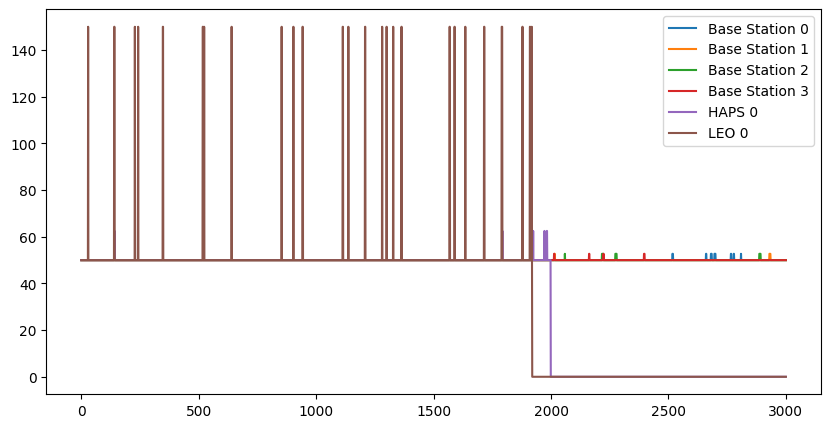

In [11]:
df.plot(kind="line", figsize=(10, 5))
plt.show()

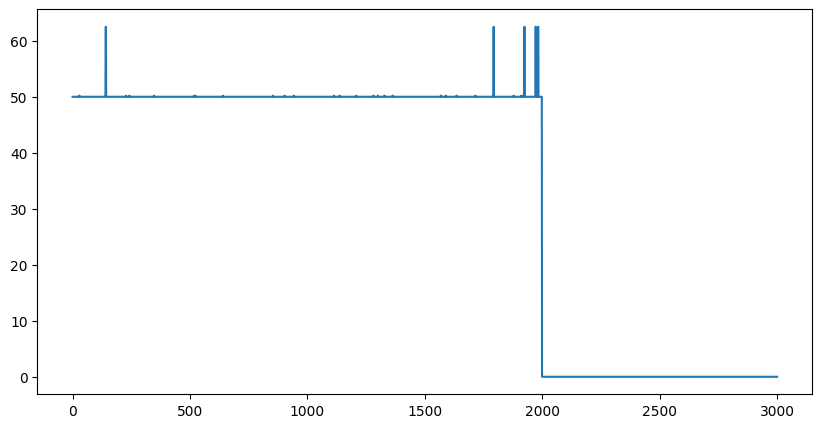

In [12]:
df = df["HAPS 0"]

df.plot(kind="line", figsize=(10, 5))
plt.show()

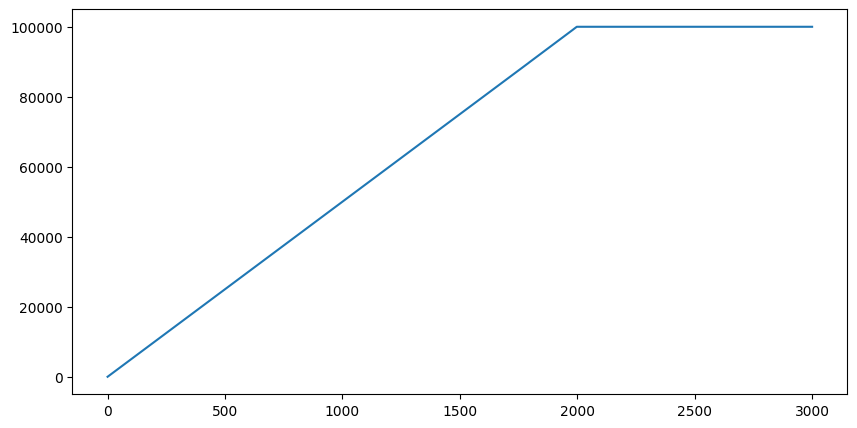

In [13]:
cum_df = df.cumsum()

cum_df.plot(kind="line", figsize=(10, 5))
plt.show()